In [ ]:
# default_exp normalization

# Normalization
The normalization step of MS-EmpiRe aims at reducing systematic biases between samples. Such biases can for example occur when more material is pipetted in one of the samples. In principle, two steps are performed:

1. Normalize between samples of the same condition (i.e. replicates)

2. Normalize between different conditions




## Within-condition normalization
It is common practice and highly recommended to measure multiple samples of a given condition. This ensures that observed changes between conditions are not just due to random variation. Examples of samples within the same condition could be biological replicates, but also patients with the same clinical condition. 
We want to ensure that systematic changes between within-condition samples are corrected for as follows:

* Our assumed input values are log2 transformed peptide ion intensities, which are stored in a 2d numpy array called "samples". Each row in samples represents a peptide and each column represents a sample

* In a first step, we determine the all pairwise distances between the samples (details explained below)
* We then choose the pair of samples with the closest distance between each other
* We randomly choose one "anchor" sample and one "shift" sample and we subtract the distance between the samples from each peptide intensity measured in the "shift" sample. This is equivalent to rescaling the intensities of the original sample by a constant factor such that the distributions are aligned
* We then construct a virtual "merged" sample by computing the average intensities of anchor and shift sample
* We repeat the steps above until all samples are merged. Keeping track of the shift factors allows us then to determine an ideal shift for each sample



In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt

def normalize_withincond(samples):

    "finds optimal scaling factors for samples measured in the same condition and corrects the samples by these scaling factors"

    num_samples = samples.shape[0]
    mergedsamples = samples #the virtual "merged" samples will be stored in this array
    sampleidx2shift = dict(zip(range(num_samples), np.zeros(num_samples))) #the scaling factors applied to the samples are stored here
    sampleidx2counts = dict(zip(range(num_samples), np.ones(num_samples)))#keeps track of how many distributions are merged
    sampleidx2anchoridx = {} #keeps track of the shifted samples
    exclusion_set = set() #already clustered samples are stored here

    for rep in range(num_samples-1):

        anchor_idx, shift_idx, min_distance = get_bestmatch_pair(mergedsamples, exclusion_set, sampleidx2counts) #determine the closest pair of samples (one "shift" sample to be shifted and one                                                                                                              "anchor sample which stays the same") and the distance between this pair
        #update the sets
        sampleidx2anchoridx.update({shift_idx : anchor_idx})
        sampleidx2shift.update({shift_idx : min_distance })
        exclusion_set.add(shift_idx)

        anchor_sample = samples[anchor_idx]
        shift_sample = samples[shift_idx]
        shifted_sample = shift_sample - min_distance
        merged_sample = merge_distribs(anchor_sample, shifted_sample, sampleidx2counts[anchor_idx], sampleidx2counts[shift_idx])
        sampleidx2counts[anchor_idx]+=1
    
    for i in range(num_samples):
        shift = get_total_shift(sampleidx2anchoridx, sampleidx2shift, i)
        samples[i] = samples[i]+shift
        
    return samples


### Find the best matching pair
Take all pairs of the columns in the "samples" array that have not been already merged and compute the distance between the pairs as follows:
* Subtract sample1 from sample2 (or sample2 from sample1, the order does not matter)
* This results in a distribution of differences. As the samples array contains log2 intensities, this corresponds to taking log2 fold changes
* Take the median of the distribution, this is a good approximation for the change between the two distributions
* Select the two samples with the lowest absolute change

In [ ]:
#export
def get_bestmatch_pair(samples, exclusion_set, sample2counts):
    "finds the pair of samples whose median values are closest to each other"
    i_min=None
    j_min=None
    min_distance = float('inf')

    for i in range(samples.shape[0]):
        if(i in exclusion_set):#if a sample has already been merged, it is written in the exclusion set
            continue
        for j in range(i+1, samples.shape[0]):#do every comparison once
            if(j in exclusion_set):
                continue
            distance = np.median(get_fcdistrib(samples[i], samples[j])) #the median of the shifted distribution is taken as the distance measure
            if abs(distance) < min_distance:
                i_min = i
                j_min = j
                min_distance = distance

    
    return determine_anchor_and_shift_sample(sample2counts, i_min, j_min, min_distance)

In [ ]:
#export
def get_fcdistrib(logvals_rep1, logvals_rep2):
    "generates difference distribution between two samples"
    dist = np.subtract(logvals_rep1, logvals_rep2)
    return dist
    

In [ ]:
#export
def determine_anchor_and_shift_sample(sample2counts, i_min, j_min, min_distance):
    "given two samples, determine the sample with fewer merges as the shift"
    counts_i = sample2counts[i_min]
    counts_j = sample2counts[j_min]
    anchor_idx = i_min if counts_i>=counts_j else j_min #ask Max for more elegant solution
    shift_idx = j_min if anchor_idx == i_min else i_min
    flip = 1 if anchor_idx == i_min else -1
    return anchor_idx, shift_idx, flip*min_distance



### Shifting samples
When we have computed the distance between two samples, we want to correct one of the samples by this distance. This results in two distributions with the same median value. We always shift the sample which has been merged from fewer distributions (see below for details). The sample to which the shift is applied is call "shift" sample and the sample which is not shifted is called "anchor" sample.
A "total shift" is calculated after all samples are merged, just by following up how many shifts have been applied to a sample in total

In [ ]:
#export
def shift_samples(samples, sampleidx2anchoridx, sample2shift):
    for sample_idx in range(samples.shape[0]):
        samples[sample_idx] = samples[sample_idx]+get_total_shift(sampleidx2anchoridx, sample2shift, sample_idx)


In [ ]:
#export
def get_total_shift(sampleidx2anchoridx, sample2shift,sample_idx):

    total_shift = 0.0
    
    while(True):
        total_shift +=sample2shift[sample_idx] 
        if sample_idx not in sampleidx2anchoridx: #every shifted sample has an anchor
            break
        sample_idx = sampleidx2anchoridx[sample_idx] 
        
    return total_shift


In [ ]:
""" #hide
def test_shift_samples():
    #assume we shift sample 1 to 2, and then sample 2 to 3
    sampleidx2anchoridx_test = {0:1, 1:2}
    #the first shift is 5 and the second shift is 10
    sample2shift_test = {0:5, 1:5,2:0}
    samples_test = np.array([[1,1,1], [6,6,6], [11,11,11]])
    print(shift_samples(samples_test, sampleidx2anchoridx_test,sample2shift_test))
    assert shift_samples(samples_test, sampleidx2anchoridx_test,sample2shift_test) == np.array([[1,1,1], [1,1,1], [1,1,1]])

test_shift_samples() """

' #hide\ndef test_shift_samples():\n    #assume we shift sample 1 to 2, and then sample 2 to 3\n    sampleidx2anchoridx_test = {0:1, 1:2}\n    #the first shift is 5 and the second shift is 10\n    sample2shift_test = {0:5, 1:5,2:0}\n    samples_test = np.array([[1,1,1], [6,6,6], [11,11,11]])\n    print(shift_samples(samples_test, sampleidx2anchoridx_test,sample2shift_test))\n    assert shift_samples(samples_test, sampleidx2anchoridx_test,sample2shift_test) == np.array([[1,1,1], [1,1,1], [1,1,1]])\n\ntest_shift_samples() '

### Merging distributions
After we shift two distributions on top of each other, we calculate a "merged" distribution. Each intensity in the merged distribution is the average of the intensity in both distributions. For the merging we have to take into account the following: If for example the anchor sample has already been merged from 10 samples, and the shift distribution has not been merged at all, we want to weigh the distribution coming from many samples higher. We hence multiply each sample by the number of merges.

In [ ]:
#export
def merge_distribs(anchor_distrib, shifted_distrib,counts_anchor_distrib, counts_shifted_distrib):
    "Calculate the average peptide intensities to merge two peptide distributions"
    return (anchor_distrib *counts_anchor_distrib + shifted_distrib*counts_shifted_distrib)/(counts_anchor_distrib+counts_shifted_distrib)

In [ ]:
#hide
def test_merged_distribs():
    anchor_distrib = np.array([1, 1, 1, 1, 1])
    shift_distrib = np.array([2, 2, 2, 2, 2])
    counts_anchor_distrib = 4
    counts_shifted_distib = 1
    assert (merge_distribs(anchor_distrib, shift_distrib, counts_anchor_distrib, counts_shifted_distib)== np.array([1.2, 1.2, 1.2, 1.2, 1.2])).any()

test_merged_distribs()

In [ ]:
#hide
def generate_randarrays(number_arrays,size_of_array):
    randarray = []
    for i in range(number_arrays):
        shift = np.random.uniform(low=-10, high=+10)
        print("array generated sample {} mean {}".format(i, shift))
        randarray.append(np.random.normal(loc=shift, size=size_of_array))
    return np.array(randarray)


In [ ]:
#hide
rand1 = np.random.normal(loc=1, size=100000)
rand2 = np.random.normal(loc=2, size=100000)
rand3 = np.random.normal(loc=3, size=100000)
rand4 = np.random.normal(loc=-10, size=100000)
rand5 = np.random.normal(loc=-11, size=100000)

randarray = np.array([rand1, rand2, rand3, rand4, rand5])

array generated sample 0 mean 9.564802604612435
array generated sample 1 mean -2.6355498798576793
array generated sample 2 mean -4.840711309033894
array generated sample 3 mean 0.977210057432746
array generated sample 4 mean 5.431265241065892
array generated sample 5 mean -2.4279422206447654
array generated sample 6 mean -1.57272139675114
array generated sample 7 mean -1.1700011521214115
array generated sample 8 mean -6.697337962144978
array generated sample 9 mean 1.6882777703006404
array generated sample 10 mean 1.054413836763013
array generated sample 11 mean 6.5712312959151795
array generated sample 12 mean 8.311077903094581
array generated sample 13 mean -5.5679807987677865
array generated sample 14 mean 2.381855552733189
array generated sample 15 mean 2.4815770202501604
array generated sample 16 mean -6.695026300118361


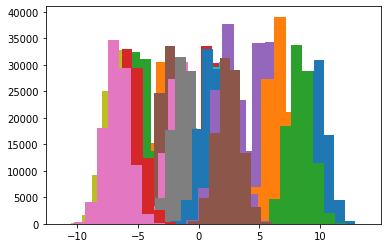

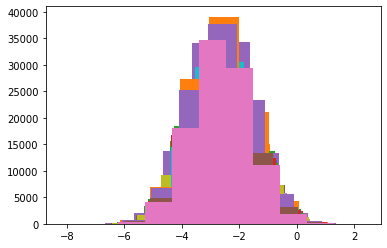

In [ ]:
#hide
def plot_samples(samples):
    num_samples = samples.shape[0]
    for i in range(num_samples):
        plt.hist(samples[i])
    plt.show()

randarray = generate_randarrays(17, 100000)
plot_samples(randarray)
normalized_randarray = normalize_withincond(randarray)
plot_samples(normalized_randarray)